In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Input, LayerNormalization, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')


In [7]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
# Load Dataset
df = pd.read_csv('../data/processed/hourly_features_data.csv', parse_dates=['timestamp'], index_col='timestamp')
targets = [
    'Energy Produced (Wh)',
    'Energy Consumed (Wh)',
    'net_export_import_grid'
]
df = df.dropna(subset=targets).select_dtypes(include=[np.number])

# df = df.drop(columns=targets).select_dtypes(include=[np.number]).dropna()
df.head()

,Studer Output Frequency - L1,Studer Output Frequency - L2,Studer Output Frequency - L3,Grid Input Frequency - L1,Grid Input Frequency - L2,Grid Input Frequency - L3,Grid Input Voltage - L2,Grid Input Voltage - L3,Studer Grid Status - L1,Studer Grid Status - L2,...,Imported from Grid (Wh)_lag72,Imported from Grid (Wh)_roll_mean_3,Imported from Grid (Wh)_roll_std_3,Imported from Grid (Wh)_roll_mean_6,Imported from Grid (Wh)_roll_std_6,Imported from Grid (Wh)_roll_mean_24,Imported from Grid (Wh)_roll_std_24,weather_severity,weather_intensity,weather_impact
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-09-08 06:00:00,49.933333,49.933333,49.933333,49.933833,49.933333,49.932833,250.133333,247.350000,1.0,1.0,...,70.25,86.500000,10.213349,90.083333,7.897257,58.833333,41.866160,1,1.0,1.0
2023-09-08 08:00:00,50.033000,50.033500,50.033500,50.033500,50.033500,50.032000,249.366667,241.983333,1.0,1.0,...,73.00,43.166667,38.697814,68.291667,36.852889,56.718750,43.524126,1,1.0,1.0
2023-09-08 09:00:00,50.029000,50.029500,50.028500,50.028500,50.029500,50.027500,248.883333,246.233333,1.0,1.0,...,67.50,18.250000,31.609927,52.375000,42.881450,56.604167,43.675739,1,1.0,1.0
2023-09-08 10:00:00,50.040500,50.041000,50.040500,50.041000,50.040500,50.040500,252.850000,247.766667,1.0,1.0,...,73.25,0.000000,0.000000,37.125000,42.452547,56.604167,43.675739,1,1.0,1.0
2023-09-08 11:00:00,50.019000,50.019500,50.019000,50.019000,50.019500,50.018000,253.066667,247.833333,1.0,1.0,...,65.50,0.000000,0.000000,21.583333,34.029644,56.604167,43.675739,1,1.0,1.0


In [9]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff) * 100


In [10]:
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(10, 4))
    plt.plot(y_true[:300], label='True')
    plt.plot(y_pred[:300], label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()


In [11]:
feature_cols = [col for col in df.columns if col not in targets + ['timestamp']]
scaler = MinMaxScaler()
df[feature_cols + targets] = scaler.fit_transform(df[feature_cols + targets])

In [12]:
def create_sequences(features, target, window):
    X, y = [], []
    for i in range(len(features) - window):
        X.append(features[i:i+window])
        y.append(target[i+window])
    return np.array(X), np.array(y)


In [13]:
def train_lstm(X_train, y_train, X_test, y_test, target, results):
    # LSTM
    print("Model: LSTM")
    
    lstm_model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        BatchNormalization(),
        LSTM(32),  # This one reduces to 2D output
        Dropout(0.3),
        Dense(1)
    ])
    
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2,
              callbacks=[EarlyStopping(patience=7, restore_best_weights=True)],
              verbose=0)
    
    y_pred = lstm_model.predict(X_test).flatten()
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    smape_score = smape(y_test, y_pred)
    
    results.append({
        "Target": target,
        "Model": "LSTM",
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "SMAPE": smape_score
    })
    
    plot_predictions(y_test, y_pred, "LSTM Predictions")
    
    return results

In [14]:
def train_gru(X_train, y_train, X_test, y_test, target, results):
    # GRU
    print("Model: GRU")
    
    gru_model = Sequential([
        GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        BatchNormalization(),
        GRU(32),  # Will now correctly receive 3D input from the first GRU
        Dropout(0.3),
        Dense(1)
    ])
    
    gru_model.compile(optimizer='adam', loss='mse')
    gru_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2,
                  callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
                  verbose=0)
    
    y_pred = gru_model.predict(X_test).flatten()
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    smape_score = smape(y_test, y_pred)
    
    results.append({
        "Target": target,
        "Model": "GRU",
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "SMAPE": smape_score
    })
    
    plot_predictions(y_test, y_pred, "LSTM Predictions")
    
    return results

In [15]:
class TransformerModel(Model):
    def __init__(self, input_shape):
        super().__init__()
        self.attn = MultiHeadAttention(num_heads=2, key_dim=input_shape[1])  # FIXED
        self.norm1 = LayerNormalization()
        self.ffn = Sequential([
            Dense(64, activation='relu'),
            Dense(input_shape[1])
        ])
        self.norm2 = LayerNormalization()
        self.global_pool = GlobalAveragePooling1D()
        self.out = Dense(1)

    def call(self, inputs):
        attn_output = self.attn(inputs, inputs)
        x = self.norm1(inputs + attn_output)
        ffn_output = self.ffn(x)
        x = self.norm2(x + ffn_output)
        x = self.global_pool(x)
        return self.out(x)

In [16]:
def train_transformer(X_train, y_train, X_test, y_test, target, results):
    print("Model: Transformer")

    transformer_model = TransformerModel((X_train.shape[1], X_train.shape[2]))
    transformer_model.compile(optimizer='adam', loss='mse')

    transformer_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=0)
    transformer_pred = transformer_model.predict(X_test)

    mae = mean_absolute_error(y_test, transformer_pred)
    rmse = np.sqrt(mean_squared_error(y_test, transformer_pred))
    r2 = r2_score(y_test, transformer_pred)
    smape_score = smape(y_test, transformer_pred)

    results.append({
        "Target": target,
        "Model": "Transformer",
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "SMAPE": smape_score
    })

    plot_predictions(y_test, transformer_pred, "Transformer Predictions")

    return results


Target: Energy Produced (Wh)
Model: LSTM
36/36 [==============================] - 1s 6ms/step


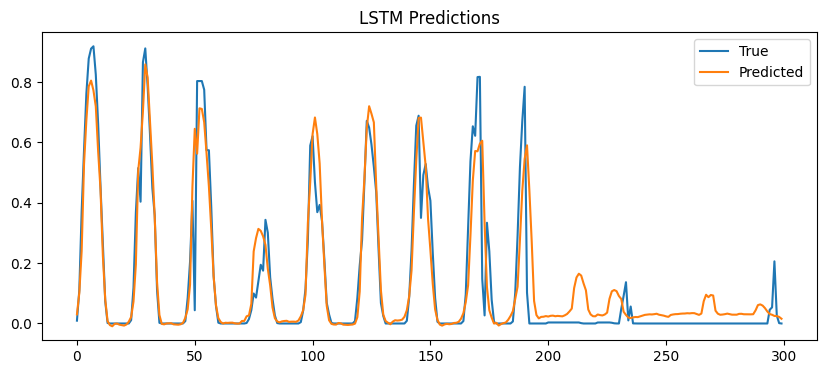

Model: GRU
36/36 [==============================] - 1s 6ms/step


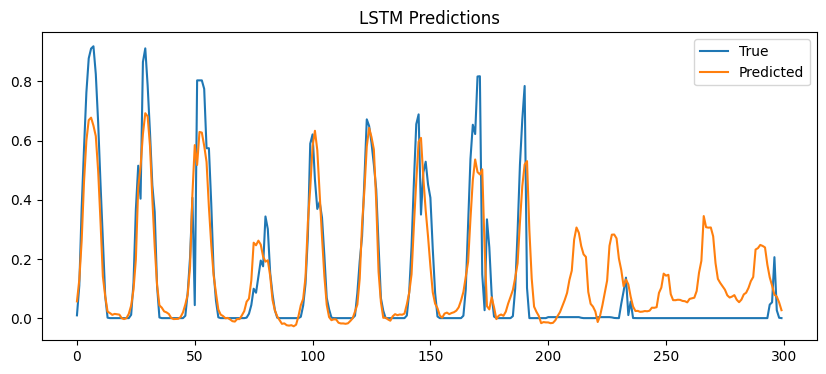

Model: Transformer
36/36 [==============================] - 0s 5ms/step


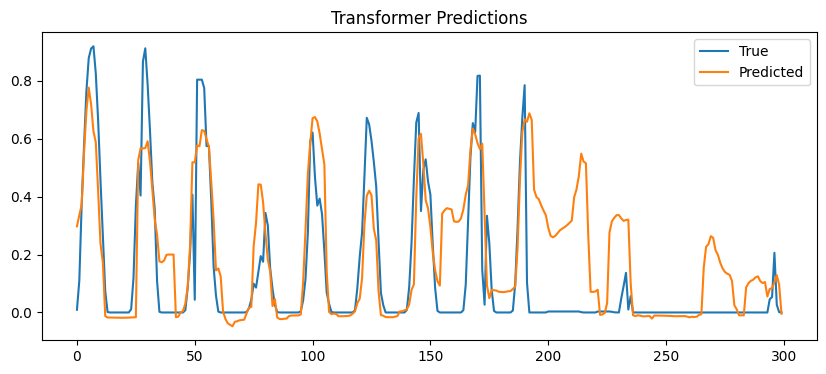

Target: Energy Consumed (Wh)
Model: LSTM
36/36 [==============================] - 1s 7ms/step


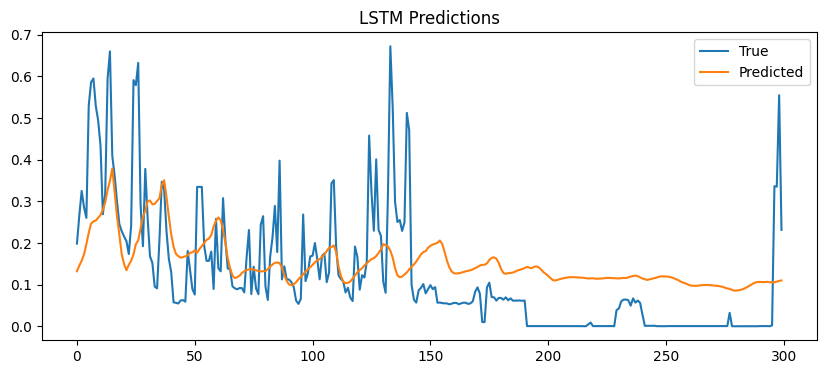

Model: GRU
36/36 [==============================] - 1s 9ms/step


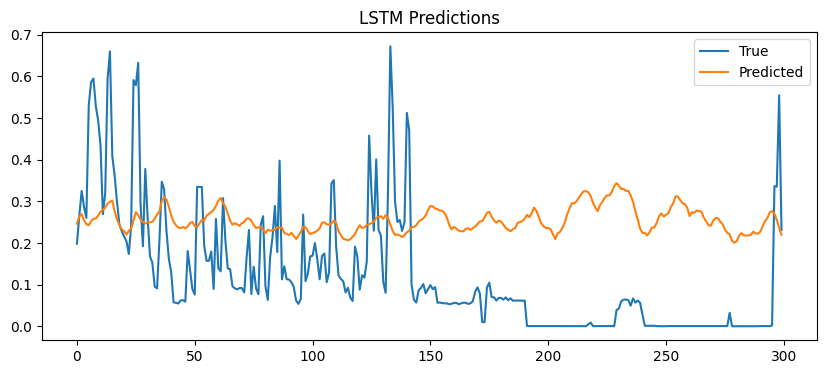

Model: Transformer
36/36 [==============================] - 0s 5ms/step


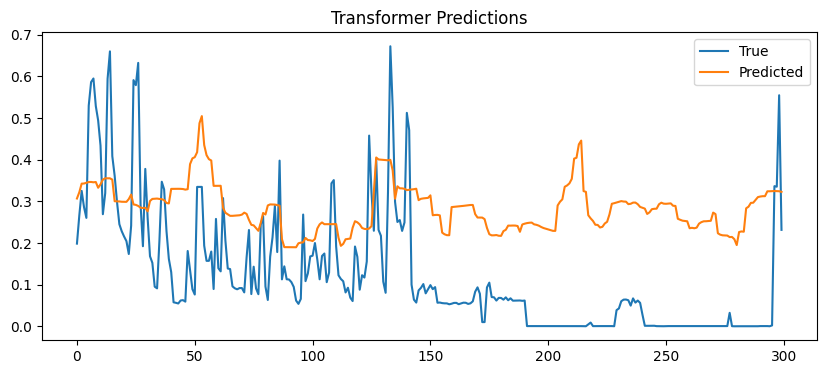

Target: net_export_import_grid
Model: LSTM
36/36 [==============================] - 1s 5ms/step


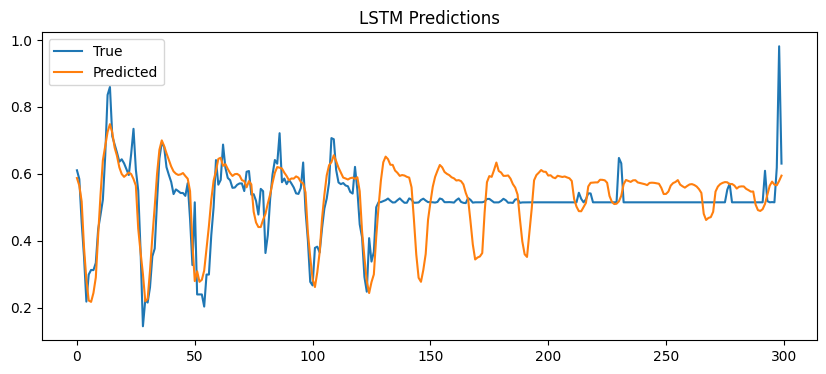

Model: GRU
36/36 [==============================] - 1s 7ms/step


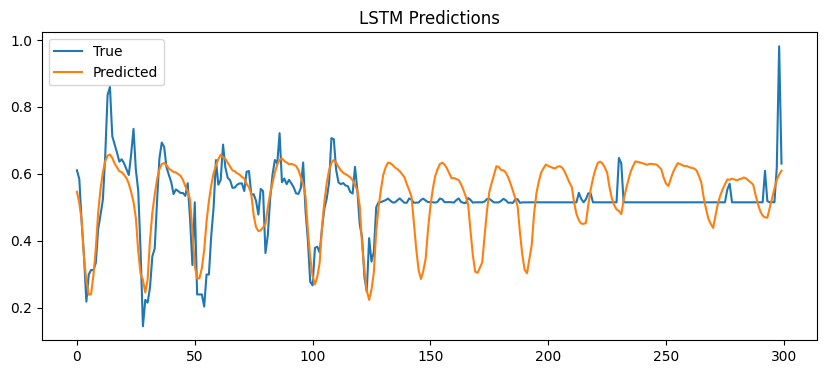

Model: Transformer
36/36 [==============================] - 0s 5ms/step


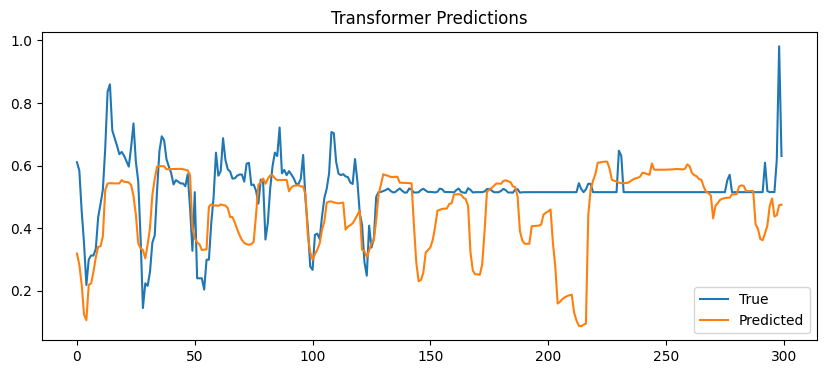

In [17]:
window_size = 24
results = []

for target in targets:
    print(f"Target: {target}")
    data = df[feature_cols + [target]].copy()
    X = data[feature_cols].values
    y = data[target].values

    X_seq, y_seq = create_sequences(X, y, window_size)
    train_size = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:train_size], X_seq[train_size:]
    y_train, y_test = y_seq[:train_size], y_seq[train_size:]

    train_lstm(X_train, y_train, X_test, y_test, target, results)
    train_gru(X_train, y_train, X_test, y_test, target, results)
    train_transformer(X_train, y_train, X_test, y_test, target, results)


In [18]:
results_df = pd.DataFrame(results)
results_df = results_df[['Target', 'Model', 'MAE', 'RMSE', 'SMAPE', 'R2']]
results_df.sort_values(by='Target').round(2)

,Target,Model,MAE,RMSE,SMAPE,R2
3,Energy Consumed (Wh),LSTM,0.10,0.15,61.92,0.37
4,Energy Consumed (Wh),GRU,0.16,0.19,78.05,-0.01
5,Energy Consumed (Wh),Transformer,0.16,0.19,83.75,0.06
0,Energy Produced (Wh),LSTM,0.06,0.10,124.78,0.81
1,Energy Produced (Wh),GRU,0.07,0.11,127.47,0.78
2,Energy Produced (Wh),Transformer,0.11,0.17,168.53,0.47
6,net_export_import_grid,LSTM,0.06,0.08,11.88,0.57
7,net_export_import_grid,GRU,0.07,0.10,14.04,0.40
8,net_export_import_grid,Transformer,0.10,0.15,28.09,-0.41
